In [309]:
from openbb_terminal.sdk import openbb
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report


%matplotlib inline

In [150]:
#setup for multiple stocks & close prices
start = "2018-01-01"
end = "2023-04-10"

symbols = ["SPY", "QQQ", "IWM", "GLD", "TLT"]

stock_data = openbb.economy.index(symbols, start_date = start, end_date = end)
stock_data

,SPY,QQQ,IWM,GLD,TLT
Date,,,,,
2018-01-02,245.828430,152.886780,143.941162,125.150002,112.310883
2018-01-03,247.383362,154.372345,144.090820,124.820000,112.847847
2018-01-04,248.426025,154.642441,144.474274,125.459999,112.829994
2018-01-05,250.081543,156.195541,144.773529,125.330002,112.507797
2018-01-08,250.538879,156.803253,144.998062,125.309998,112.436195
...,...,...,...,...,...
2023-03-31,409.390015,320.929993,178.399994,183.220001,106.101006
2023-04-03,410.950012,320.149994,178.479996,184.539993,106.599998
2023-04-04,408.670013,319.070007,175.350006,187.979996,107.129997


<AxesSubplot: title={'left': 'Index Overview - 5yr Daily'}, xlabel='Date'>

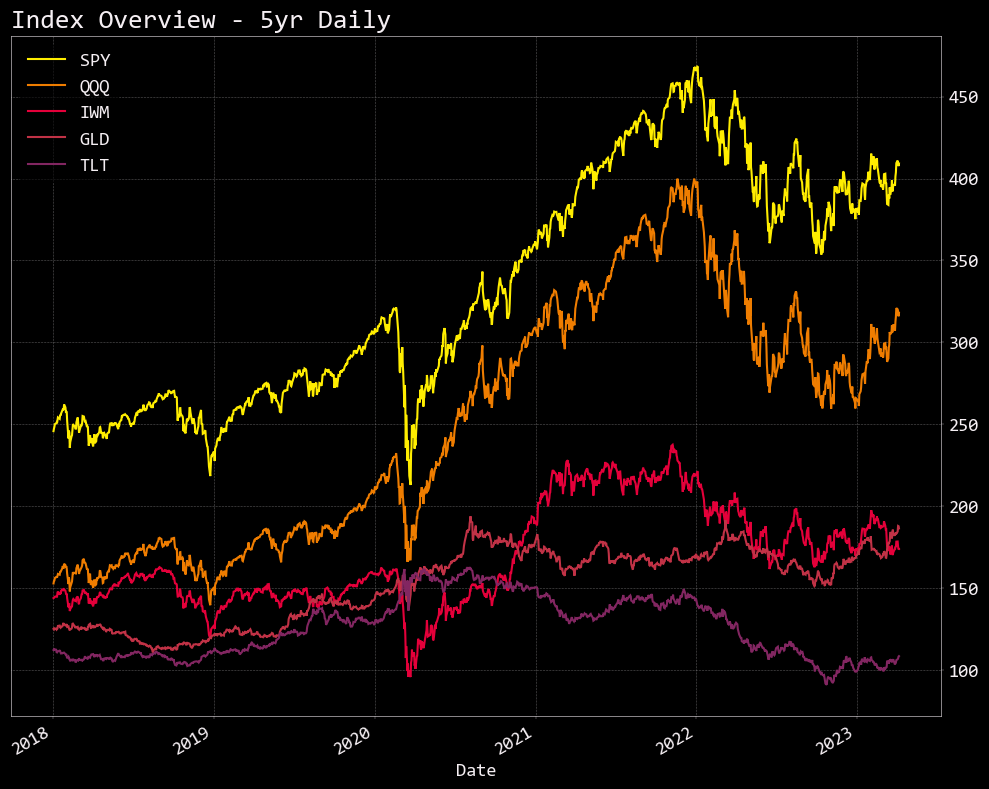

In [151]:
# Quick Examine of the Daily Plot to level set the overall environment 
stock_data.plot(
    title="Index Overview - 5yr Daily",
    figsize=(12,10)
)

In [239]:
#Drill into single issue --> TSCO
iwm_data = openbb.stocks.load(
        symbol = 'TSCO',
        start_date = start,
        monthly = False)
iwm_data.head()

Loading Daily data for TSCO with starting period 2018-01-02.

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
date,,,,,,,,
2018-01-02,69.908285,71.188627,69.592843,70.214455,70.214455,1590000,0.0,0.0
2018-01-03,70.362908,70.845358,69.991801,70.743301,70.743301,786100,0.0,0.0
2018-01-04,70.984521,72.107135,70.594848,72.014359,72.014359,1225700,0.0,0.0
2018-01-05,72.264871,73.786431,72.079317,73.702934,73.702934,2160100,0.0,0.0
2018-01-08,73.452425,73.962708,73.025647,73.526649,73.526649,1409700,0.0,0.0


Loading Daily data for TSCO with starting period 2020-04-08.

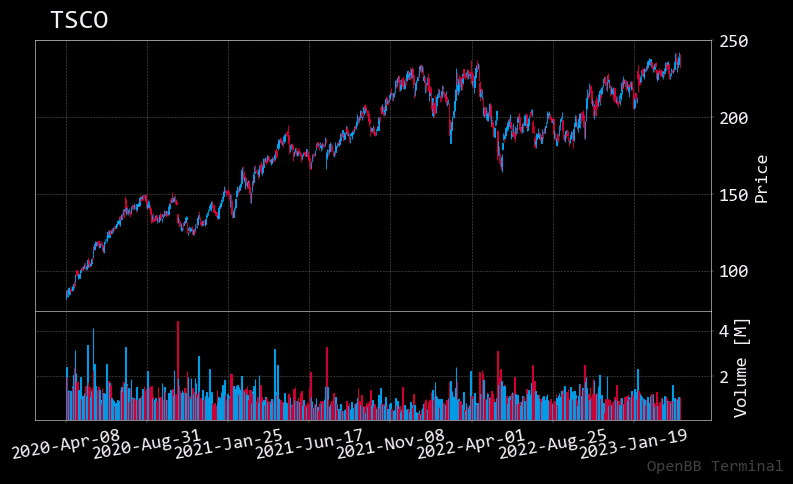

In [240]:
#Zoom in to get a feel for our data on both daily and intraday windows
openbb.stocks.candle("TSCO")

Loading Intraday 15min data for TSCO with starting period 2023-02-13.

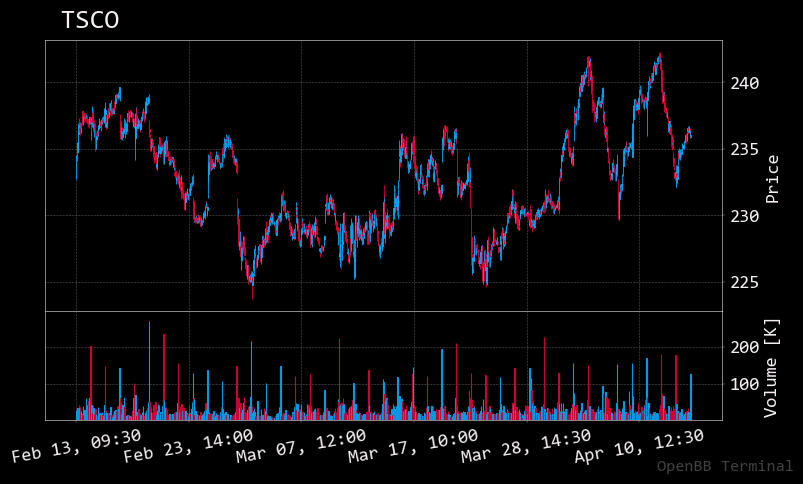

In [241]:
openbb.stocks.candle("TSCO", interval=15)

In [242]:
# Begin "manual" ML process

# remove split & dividends from df
iwm_data = iwm_data.drop(columns=["Dividends", "Stock Splits"])

# Filter the date index and close columns
iwm_signals_df = iwm_data.loc[:, ["Close"]]

# Use the pct_change function to generate returns from close prices
iwm_signals_df["Actual Returns"] = iwm_signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
iwm_signals_df = iwm_signals_df.dropna()

# Review the DataFrame
display(iwm_signals_df.head())
display(iwm_signals_df.tail())

,Close,Actual Returns
date,,
2018-01-03,70.743301,0.007532
2018-01-04,72.014359,0.017967
2018-01-05,73.702934,0.023448
2018-01-08,73.526649,-0.002392
2018-01-09,73.749306,0.003028


,Close,Actual Returns
date,,
2023-04-05,234.529999,-0.021119
2023-04-06,235.630005,0.004690
2023-04-10,238.550003,0.012392
2023-04-11,240.000000,0.006078
2023-04-12,232.639999,-0.030667


In [243]:
# Set the short window and long window (10 & 60 as this will be comparison later to openbb signals)
short_window = 10
long_window = 60

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
iwm_signals_df['SMA_Short(10)'] = iwm_signals_df['Close'].rolling(window=short_window).mean()
iwm_signals_df['SMA_Long(60)'] = iwm_signals_df['Close'].rolling(window=long_window).mean()

#drop any null values
iwm_signals_df = iwm_signals_df.dropna()

# Review the DataFrame
display(iwm_signals_df.head())
display(iwm_signals_df.tail())

,Close,Actual Returns,SMA_Short(10),SMA_Long(60)
date,,,,
2018-03-29,58.709705,0.050333,57.228448,64.622925
2018-04-02,56.259575,-0.041733,56.856738,64.381529
2018-04-03,56.650852,0.006955,56.634084,64.125471
2018-04-04,57.647682,0.017596,56.546515,63.857883
2018-04-05,57.163231,-0.008404,56.499003,63.585160


,Close,Actual Returns,SMA_Short(10),SMA_Long(60)
date,,,,
2023-04-05,234.529999,-0.021119,232.475,228.299674
2023-04-06,235.630005,0.004690,233.377,228.547511
2023-04-10,238.550003,0.012392,234.511,228.846338
2023-04-11,240.000000,0.006078,235.534,229.183601
2023-04-12,232.639999,-0.030667,235.847,229.392390


In [244]:
# Initialize the new Signal column
iwm_signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
iwm_signals_df.loc[(iwm_signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
iwm_signals_df.loc[(iwm_signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(iwm_signals_df.head())
display(iwm_signals_df.tail())

,Close,Actual Returns,SMA_Short(10),SMA_Long(60),Signal
date,,,,,
2018-03-29,58.709705,0.050333,57.228448,64.622925,1.0
2018-04-02,56.259575,-0.041733,56.856738,64.381529,-1.0
2018-04-03,56.650852,0.006955,56.634084,64.125471,1.0
2018-04-04,57.647682,0.017596,56.546515,63.857883,1.0
2018-04-05,57.163231,-0.008404,56.499003,63.585160,-1.0


,Close,Actual Returns,SMA_Short(10),SMA_Long(60),Signal
date,,,,,
2023-04-05,234.529999,-0.021119,232.475,228.299674,-1.0
2023-04-06,235.630005,0.004690,233.377,228.547511,1.0
2023-04-10,238.550003,0.012392,234.511,228.846338,1.0
2023-04-11,240.000000,0.006078,235.534,229.183601,1.0
2023-04-12,232.639999,-0.030667,235.847,229.392390,-1.0


In [245]:
# Check to see distribution of signals
iwm_signals_df['Signal'].value_counts()

 1.0    682
-1.0    586
Name: Signal, dtype: int64

In [246]:
# Calculate the strategy returns and add them to the signals_df DataFrame
iwm_signals_df['Strategy Returns'] = iwm_signals_df['Actual Returns'] * iwm_signals_df['Signal'].shift()

# Review the DataFrame
display(iwm_signals_df.head())
display(iwm_signals_df.tail())

,Close,Actual Returns,SMA_Short(10),SMA_Long(60),Signal,Strategy Returns
date,,,,,,
2018-03-29,58.709705,0.050333,57.228448,64.622925,1.0,NaN
2018-04-02,56.259575,-0.041733,56.856738,64.381529,-1.0,-0.041733
2018-04-03,56.650852,0.006955,56.634084,64.125471,1.0,-0.006955
2018-04-04,57.647682,0.017596,56.546515,63.857883,1.0,0.017596
2018-04-05,57.163231,-0.008404,56.499003,63.585160,-1.0,-0.008404


,Close,Actual Returns,SMA_Short(10),SMA_Long(60),Signal,Strategy Returns
date,,,,,,
2023-04-05,234.529999,-0.021119,232.475,228.299674,-1.0,0.021119
2023-04-06,235.630005,0.004690,233.377,228.547511,1.0,-0.004690
2023-04-10,238.550003,0.012392,234.511,228.846338,1.0,0.012392
2023-04-11,240.000000,0.006078,235.534,229.183601,1.0,0.006078
2023-04-12,232.639999,-0.030667,235.847,229.392390,-1.0,-0.030667


### Split the data into training and testing datasets.

In [248]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = iwm_signals_df[['SMA_Short(10)', 'SMA_Long(60)']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Short(10),SMA_Long(60)
date,,
2018-04-02,57.228448,64.622925
2018-04-03,56.856738,64.381529
2018-04-04,56.634084,64.125471
2018-04-05,56.546515,63.857883
2018-04-06,56.499003,63.585160


In [249]:
# Create the target set selecting the Signal column and assiging it to y
y = iwm_signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    682
-1.0    586
Name: Signal, dtype: int64

In [250]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2018-04-02 00:00:00


In [251]:
# Select the ending period for the training data with an offset of 2 years
training_end = X.index.min() + DateOffset(years=2)

# Display the training end date
print(training_end)

2020-04-02 00:00:00


In [252]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Short(10),SMA_Long(60)
date,,
2018-04-02,57.228448,64.622925
2018-04-03,56.856738,64.381529
2018-04-04,56.634084,64.125471
2018-04-05,56.546515,63.857883
2018-04-06,56.499003,63.585160


In [253]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Short(10),SMA_Long(60)
date,,
2020-04-03,78.186920,85.520955
2020-04-06,78.531010,85.331086
2020-04-07,79.479893,85.290688
2020-04-08,80.100020,85.219484
2020-04-09,81.419829,85.229541


In [254]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [255]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [256]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.36      0.03      0.05       350
         1.0       0.54      0.96      0.69       411

    accuracy                           0.53       761
   macro avg       0.45      0.49      0.37       761
weighted avg       0.45      0.53      0.40       761



In [257]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = iwm_signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df["Predicted"] * predictions_df["Actual Returns"]

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2020-04-03,1.0,-0.055258,-0.055258
2020-04-06,1.0,0.106415,0.106415
2020-04-07,1.0,-0.016712,-0.016712
2020-04-08,1.0,0.048676,0.048676
2020-04-09,1.0,-0.027233,-0.027233


,Predicted,Actual Returns,Strategy Returns
date,,,
2023-04-05,1.0,-0.021119,-0.021119
2023-04-06,1.0,0.004690,0.004690
2023-04-10,1.0,0.012392,0.012392
2023-04-11,1.0,0.006078,0.006078
2023-04-12,1.0,-0.030667,-0.030667


<AxesSubplot: title={'left': 'Actual vs Strategy'}, xlabel='date', ylabel='cum returns'>

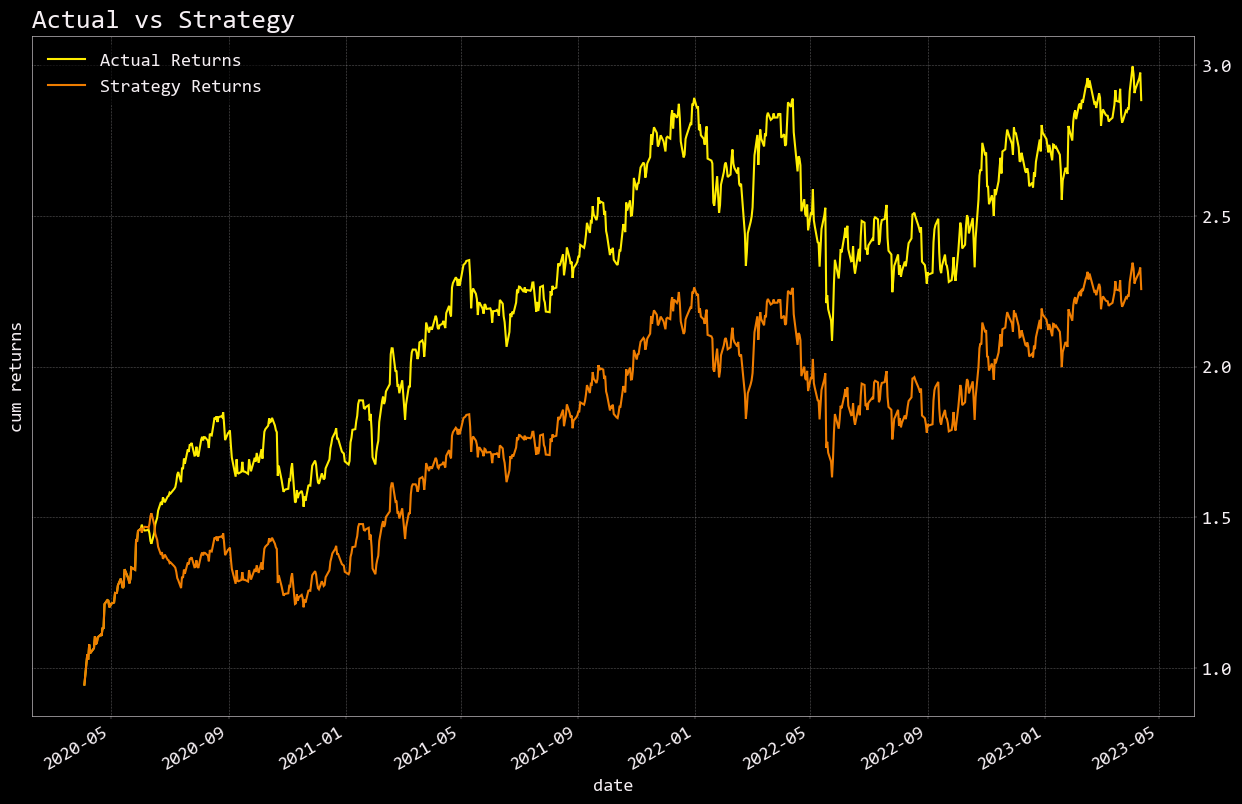

In [258]:
# Plot the actual returns versus the strategy returns
baseline = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    title = "Actual vs Strategy",
    figsize = (15,10),
    ylabel="cum returns"

)
baseline

In [259]:
# up to this point a lot of work to determine:
# 1. The strategy itself did NOT perform well in the backtest as compared to the actual returns
# 2. The SVM predictive model had poor precision and accuracy and would need alot of additional work before deploying to predict price

In [260]:
# Use the signals function
# Use the predictive modeling function to QUICKLY train test predict and evaluate a regression model

In [261]:
iwm_data

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2018-01-02,69.908285,71.188627,69.592843,70.214455,70.214455,1590000
2018-01-03,70.362908,70.845358,69.991801,70.743301,70.743301,786100
2018-01-04,70.984521,72.107135,70.594848,72.014359,72.014359,1225700
2018-01-05,72.264871,73.786431,72.079317,73.702934,73.702934,2160100
2018-01-08,73.452425,73.962708,73.025647,73.526649,73.526649,1409700
...,...,...,...,...,...,...
2023-04-05,237.539993,238.889999,232.580002,234.529999,234.529999,1030400
2023-04-06,232.740005,235.889999,229.679993,235.630005,235.630005,986500
2023-04-10,234.380005,239.789993,234.380005,238.550003,238.550003,1104100


In [262]:
# 1 if the signal is that short term price will go up as compared to the long term.
# 0 if the signal is that short term price will go down as compared to the long term.

# Create short simple moving average; the short window defaults to 10 period
# Create long simple moving average; the long window defaults to 60 period

# Single line calculates the short and long SMA's and determines the 1 or 0 for us!!

new_iwm_df = openbb.forecast.signal(iwm_data, target_column = "Adj Close")
new_iwm_df

,Open,High,Low,Close,Adj Close,Volume,signal
date,,,,,,,
2018-01-02,69.908285,71.188627,69.592843,70.214455,70.214455,1590000,0.0
2018-01-03,70.362908,70.845358,69.991801,70.743301,70.743301,786100,0.0
2018-01-04,70.984521,72.107135,70.594848,72.014359,72.014359,1225700,0.0
2018-01-05,72.264871,73.786431,72.079317,73.702934,73.702934,2160100,0.0
2018-01-08,73.452425,73.962708,73.025647,73.526649,73.526649,1409700,0.0
...,...,...,...,...,...,...,...
2023-04-05,237.539993,238.889999,232.580002,234.529999,234.529999,1030400,1.0
2023-04-06,232.740005,235.889999,229.679993,235.630005,235.630005,986500,1.0
2023-04-10,234.380005,239.789993,234.380005,238.550003,238.550003,1104100,1.0


Predicting Regression for 30 days


  0%|          | 0/339 [00:00<?, ?it/s]

Regression model obtains MAPE: 3.78%

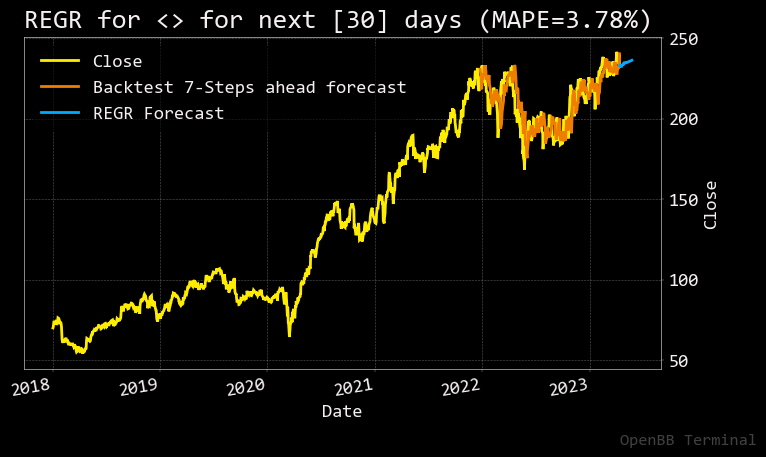

   Actual price: 232.64    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Datetime   ┃ Prediction ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ 2023-04-13 │ 232.95     │
├────────────┼────────────┤
│ 2023-04-14 │ 233.33     │
├────────────┼────────────┤
│ 2023-04-17 │ 233.12     │
├────────────┼────────────┤
│ 2023-04-18 │ 232.03     │
├────────────┼────────────┤
│ 2023-04-19 │ 232.48     │
├────────────┼────────────┤
│ 2023-04-20 │ 233.22     │
├────────────┼────────────┤
│ 2023-04-21 │ 233.44     │
├────────────┼────────────┤
│ 2023-04-24 │ 234.09     │
├────────────┼────────────┤
│ 2023-04-25 │ 233.35     │
├────────────┼────────────┤
│ 2023-04-26 │ 233.81     │
├────────────┼────────────┤
│ 2023-04-27 │ 234.25     │
├────────────┼────────────┤
│ 2023-04-28 │ 234.54     │
├────────────┼────────────┤
│ 2023-05-01 │ 234.67     │
├────────────┼────────────┤
│ 2023-05-02 │ 234.98     │
├────────────┼────────────┤
│ 2023-05-03 │ 234.91     │
├────────────┼────────────┤
│ 2023-05-04 │ 234.95     │
├────────────┼────────────┤
│ 2023-05-05 │ 235.09     │
├────────────┼────────────┤
│ 2023-05-08 │ 235.06     │
├────────────┼────────────┤
│ 2023-05-09 │ 235.17     │
├────────────┼────────────┤
│ 2023-05-10 │ 235.31     │
├────────────┼────────────┤
│ 2023-05-11 │ 235.42     │
├────────────┼────────────┤
│ 2023-05-12 │ 235.49     │
├────────────┼────────────┤
│ 2023-05-15 │ 235.63     │
├────────────┼────────────┤
│ 2023-05-16 │ 235.69     │
├────────────┼────────────┤
│ 2023-05-17 │ 235.81     │
├────────────┼────────────┤
│ 2023-05-18 │ 235.93     │
├────────────┼────────────┤
│ 2023-05-19 │ 236.05     │
├────────────┼────────────┤
│ 2023-05-22 │ 236.17     │
├────────────┼────────────┤
│ 2023-05-23 │ 236.31     │
├────────────┼────────────┤
│ 2023-05-24 │ 236.41     │
└────────────┴────────────┘

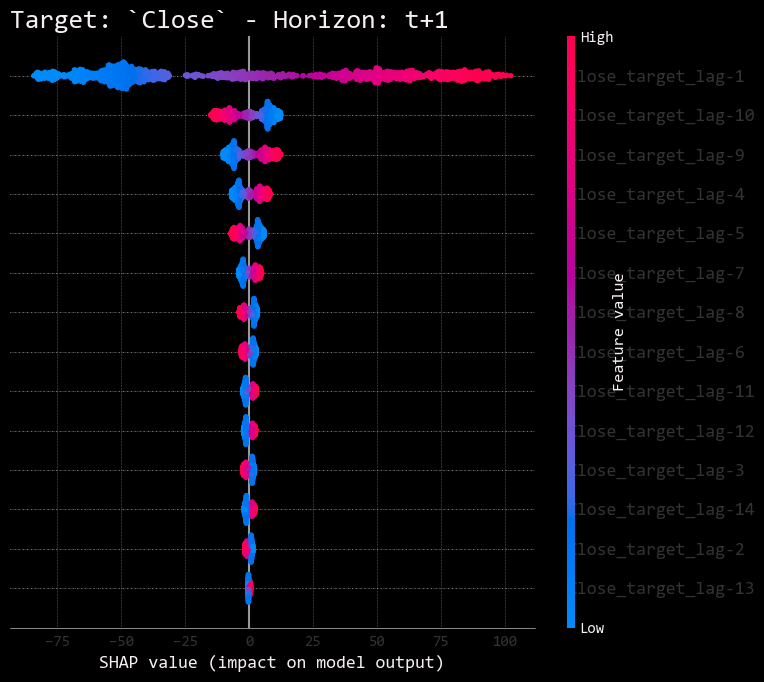

<Figure size 640x480 with 0 Axes>

In [287]:
openbb.forecast.regr_chart(data = new_iwm_df, target_column = "Close",
        n_predict = 30,
        train_split = 0.75,
        forecast_horizon = 7,
        #past_covariates = "Volume"
                          
)

In [140]:
#openbb.stocks.ca.sentiment_chart(["SPY"])

### Feature Engineering

In [267]:
#add technical indicators to the df
new_iwm_data = openbb.forecast.ema(iwm_data, target_column = 'Adj Close', period = 7)
new_iwm_data = openbb.forecast.ema(iwm_data, target_column = 'Adj Close', period = 30)
new_iwm_data = openbb.forecast.ema(iwm_data, target_column = 'Adj Close', period = 100)
new_iwm_data = openbb.forecast.rsi(iwm_data, target_column = 'Adj Close', period = 5)  #5 = trading days or 1 week
new_iwm_data = openbb.forecast.rsi(iwm_data, target_column = 'Adj Close', period = 20)  #20 = trading days or 1 month
new_iwm_data = new_iwm_data.set_index("date")
new_iwm_data

,Open,High,Low,Close,Adj Close,Volume,signal,EMA_7,EMA_30,EMA_100,RSI_5_Adj Close,RSI_20_Adj Close
date,,,,,,,,,,,,
2018-01-02,69.908285,71.188627,69.592843,70.214455,70.214455,1590000,0.0,70.214455,70.214455,70.214455,NaN,NaN
2018-01-03,70.362908,70.845358,69.991801,70.743301,70.743301,786100,0.0,70.346666,70.248574,70.224927,NaN,NaN
2018-01-04,70.984521,72.107135,70.594848,72.014359,72.014359,1225700,0.0,70.763589,70.362495,70.260361,NaN,NaN
2018-01-05,72.264871,73.786431,72.079317,73.702934,73.702934,2160100,0.0,71.498426,70.578008,70.328531,NaN,NaN
2018-01-08,73.452425,73.962708,73.025647,73.526649,73.526649,1409700,0.0,72.005482,70.768243,70.391860,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-05,237.539993,238.889999,232.580002,234.529999,234.529999,1030400,1.0,235.085763,231.531998,223.508731,50.334563,54.091539
2023-04-06,232.740005,235.889999,229.679993,235.630005,235.630005,986500,1.0,235.221824,231.796386,223.748756,54.199813,55.113921
2023-04-10,234.380005,239.789993,234.380005,238.550003,238.550003,1104100,1.0,236.053869,232.232103,224.041850,63.599755,57.743453


Warning: when using past covariates n_predict must equal output_chunk_length. We have changed your output_chunk_length to 30 to match your n_predict

Covariate #0: EMA_7

Covariate #1: EMA_30

Covariate #2: EMA_100

Predicting Regression for 30 days


  0%|          | 0/1029 [00:00<?, ?it/s]

Regression model obtains MAPE: 3.12%

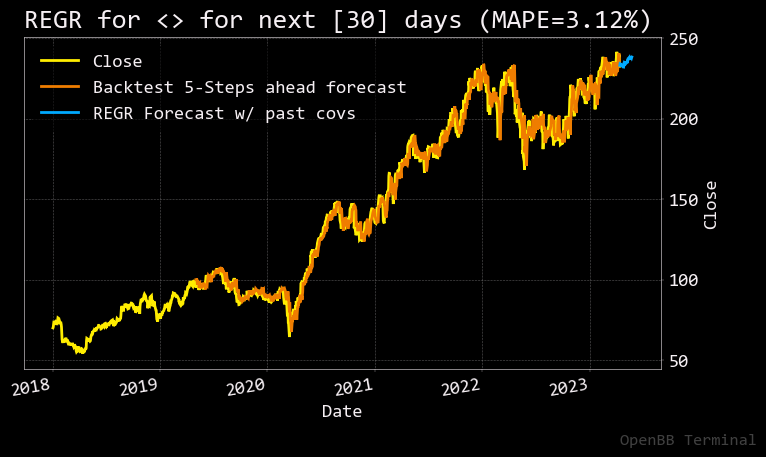

   Actual price: 232.64    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Datetime   ┃ Prediction ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ 2023-04-13 │ 233.30     │
├────────────┼────────────┤
│ 2023-04-14 │ 234.27     │
├────────────┼────────────┤
│ 2023-04-17 │ 233.96     │
├────────────┼────────────┤
│ 2023-04-18 │ 232.99     │
├────────────┼────────────┤
│ 2023-04-19 │ 232.92     │
├────────────┼────────────┤
│ 2023-04-20 │ 233.98     │
├────────────┼────────────┤
│ 2023-04-21 │ 232.87     │
├────────────┼────────────┤
│ 2023-04-24 │ 233.75     │
├────────────┼────────────┤
│ 2023-04-25 │ 232.24     │
├────────────┼────────────┤
│ 2023-04-26 │ 232.21     │
├────────────┼────────────┤
│ 2023-04-27 │ 234.58     │
├────────────┼────────────┤
│ 2023-04-28 │ 235.06     │
├────────────┼────────────┤
│ 2023-05-01 │ 234.57     │
├────────────┼────────────┤
│ 2023-05-02 │ 234.68     │
├────────────┼────────────┤
│ 2023-05-03 │ 234.23     │
├────────────┼────────────┤
│ 2023-05-04 │ 234.44     │
├────────────┼────────────┤
│ 2023-05-05 │ 234.77     │
├────────────┼────────────┤
│ 2023-05-08 │ 235.63     │
├────────────┼────────────┤
│ 2023-05-09 │ 234.63     │
├────────────┼────────────┤
│ 2023-05-10 │ 236.54     │
├────────────┼────────────┤
│ 2023-05-11 │ 237.28     │
├────────────┼────────────┤
│ 2023-05-12 │ 237.33     │
├────────────┼────────────┤
│ 2023-05-15 │ 238.09     │
├────────────┼────────────┤
│ 2023-05-16 │ 237.08     │
├────────────┼────────────┤
│ 2023-05-17 │ 236.77     │
├────────────┼────────────┤
│ 2023-05-18 │ 237.95     │
├────────────┼────────────┤
│ 2023-05-19 │ 237.99     │
├────────────┼────────────┤
│ 2023-05-22 │ 238.15     │
├────────────┼────────────┤
│ 2023-05-23 │ 237.81     │
├────────────┼────────────┤
│ 2023-05-24 │ 238.41     │
└────────────┴────────────┘

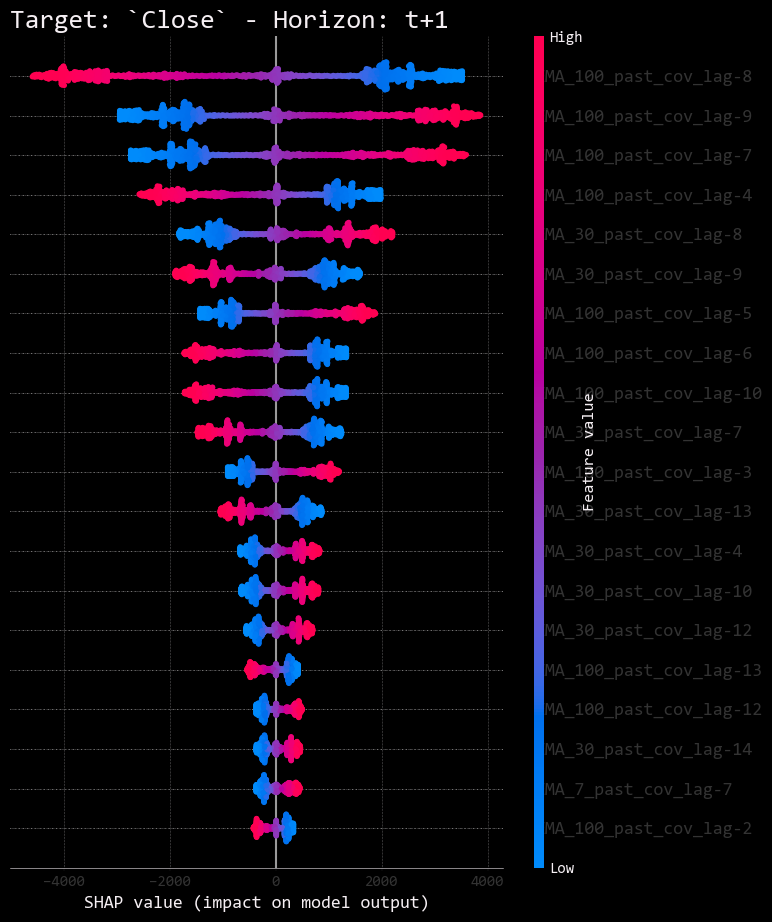

<Figure size 640x480 with 0 Axes>

In [308]:
openbb.forecast.regr_chart(data = new_iwm_df, target_column = "Close",
        n_predict = 30,
        train_split = 0.25,
        forecast_horizon = 5,
        past_covariates = "EMA_7,EMA_30,EMA_100"
                          
)

In [323]:
mape = pd.read_csv(Path("MAPE_analysis.csv"))
mape = mape.set_index("TrainData%")
mape

,forecast_horizon=5(no cov),forecast_horizon=5(EMA cov),forecast_horizon=5(combo cov),forecast_horizon=7(no cov),forecast_horizon=7(RSI cov),forecast_horizon=7(combo cov)
TrainData%,,,,,,
25,3.12,3.12,3.12,3.73,3.71,3.70
50,3.08,2.99,3.09,3.64,3.63,3.65
75,3.27,3.21,3.24,3.78,3.72,3.73
85,2.79,2.80,2.77,3.21,3.28,3.23
95,2.20,2.34,2.25,2.66,2.85,2.72


<AxesSubplot: title={'left': 'Regression Model MAPE analysis Covariates Effect'}, xlabel='TrainData%', ylabel='MAPE %'>

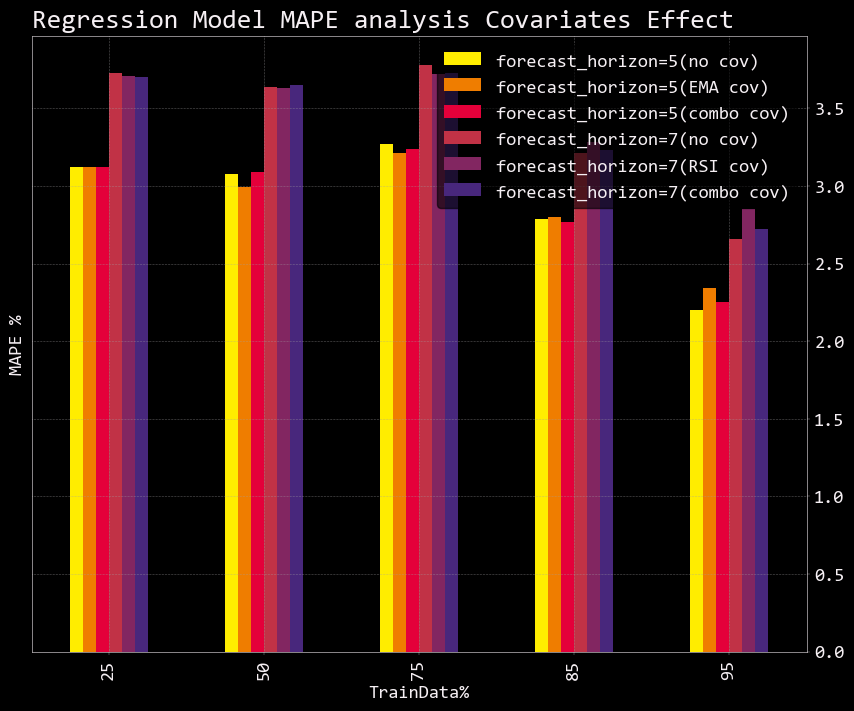

In [330]:
mape.plot(kind = "bar",
          title = "Regression Model MAPE analysis Covariates Effect",
          ylabel = "MAPE %",
          figsize = (10,8)
         
         )

In [365]:
df_topfive = pd.DataFrame([['95%/5/nocov', .0220],
                   ['95%/step5/Combocov', .0225],
                   ['95%/step5/EMAcov', .0234],
                   ['95%/step7/nocov', .0266],
                   ['95%/step7/Combocov', .0272]], columns = ['Model Parms', 'MAPE %'])

df_topfive = df_topfive.sort_values("MAPE %", ascending=False, ignore_index = True)
df_topfive

,Model Parms,MAPE %
0,95%/step7/Combocov,0.0272
1,95%/step7/nocov,0.0266
2,95%/step5/EMAcov,0.0234
3,95%/step5/Combocov,0.0225
4,95%/5/nocov,0.0220


In [334]:
import matplotlib.pyplot as plt

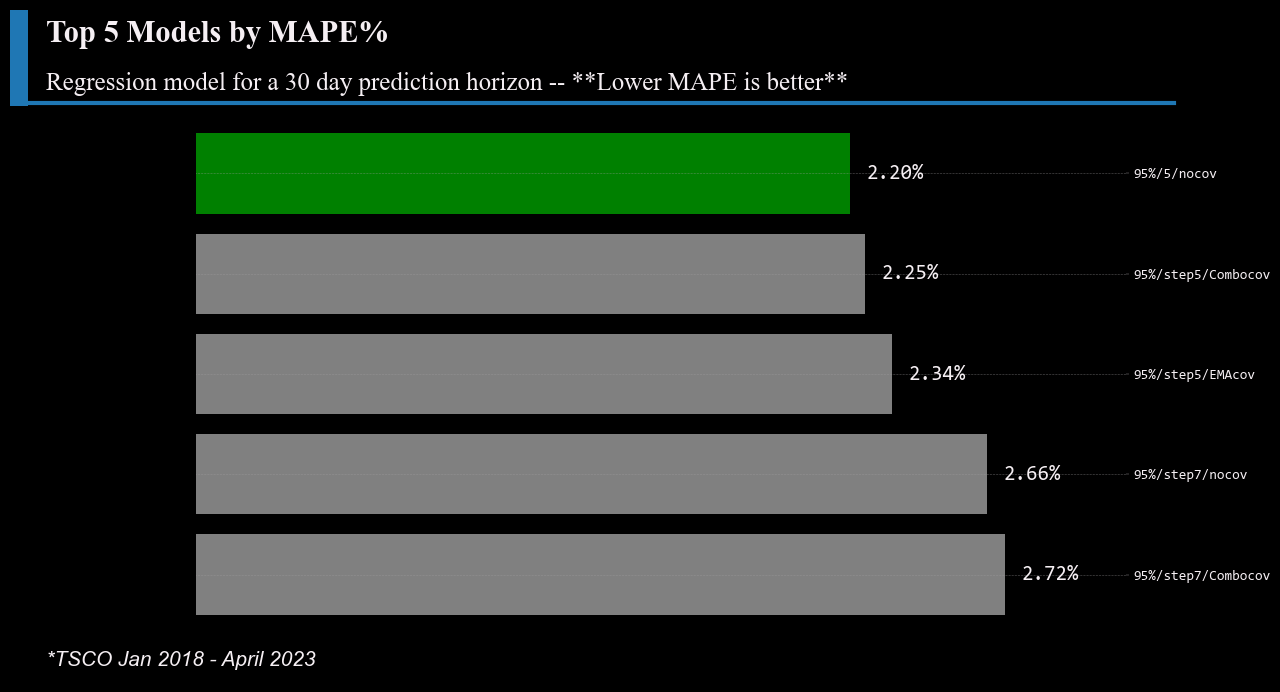

In [370]:
# Define figure
fig,ax = plt.subplots(figsize = (12,8))

# add title to plot
title = 'Top 5 Models by MAPE%'
plt.text(s=title,                      # the text to be displayed
         x = 0,y = 0.91,               # the position of the text (x, y)
         fontname = 'Times New Roman', # the font to be used for the text
         fontweight = "bold",          # the weight of the font (e.g. bold)
         fontsize = 22,                # the size of the font
         ha='left',                    # horizontal alignment of the text ('left', 'center', 'right')
         transform = fig.transFigure   # the coordinate system to use for positioning the text
)

# add subtitle to plot
subtitle = 'Regression model for a 30 day prediction horizon -- **Lower MAPE is better**'
plt.text(s=subtitle,                   # the text to be displayed
         x = 0, y = 0.85,              # the position of the text (x, y)
         fontname = 'Times New Roman', # the font to be used for the text
         fontsize = 18,                # the size of the font
         ha = 'left',                  # horizontal alignment of the text ('left', 'center', 'right')
         transform = fig.transFigure   # the coordinate system to use for positioning the text
)

# Create bar plot
bars = plt.barh(df_topfive['Model Parms'], 
                df_topfive['MAPE %'], 
                color = ['gray', 'gray', 'gray', 'gray', "green"], # color for bars
                edgecolor='none')

# add margin
plt.margins(y=0.14, x=0.15)

# remove plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# remove xlabels
ax.set_xticklabels([])
ax.set_xticks([])

# position and format ylabels
ax.tick_params(axis='y', left=False)
plt.yticks(fontsize=10, fontweight='bold')

plt.bar_label(
    bars,                                          # the bars object to add labels to
    labels=[f'{x:.2%}' for x in bars.datavalues],  # the list of labels to display on each bar
    padding=12,                                    # padding between the bar and the label
    fontsize=15                                    # font size of the labels
)
# add line
ax.plot(
    [-0.025, .94],                # X-coordinates of the ends of the line
    [.8335, .8335],               # Y-coordinates of the ends of the line
    transform = fig.transFigure,  # Coordinate system for the line
    clip_on = False,              # Whether to clip the line to the axes bounds
    color = 'tab:blue',           # Color of the line
    linewidth = 3                 # Width of the line
)


# add rectangle
ax.add_patch(
    plt.Rectangle(
        (-0.03,.95),                   # (x, y) location of the bottom-left corner of the rectangle
        0.015,                         # width of the rectangle
        -0.12,                         # height of the rectangle
        facecolor = 'tab:blue',        # fill color of the rectangle
        transform = fig.transFigure,   # coordinate system used for the rectangle
        clip_on = False,               # whether the rectangle is drawn outside the plot area
        linewidth = 0                  # width of the edge line of the rectangle
    )
)

# add footnote
footnote = "*TSCO Jan 2018 - April 2023"
plt.text(s = footnote,
         x = 0,
         y = 0.13,
         fontname = 'Arial',
         fontstyle = 'italic',
         fontsize = 15,
         ha = 'left',
         transform = fig.transFigure
);